## When do policies make a difference

This submission focuses on the relationship between the trajectory of proliferation and the effectiveness of different policy measures within in the context of these trajectories. We study the case doubling rates of different countries in the first 100 days from when the first case was reported in the country, and the association between policy and proliferation trajectory (as indicated by the case doubling rate).


The purpose is to provide data-guided reference points for policy makers so they can easily compare the policy outcomes of countries most similar to them in proliferation trajectory (at a given point in time). While this is by no means deemed to be a definitive statement of the effectiveness of policy adoption, it can serve as an ecologically sound supplement to more controlled (but less ecologically valid) scentific studies.

This notebook was created by [c3d3](mailto:c3@c3d3.info) and uses data from [C3.ai COVID-19 Data Lake](https://c3.ai/covid/) APIs. See the [API documentation](https://c3.ai/covid-19-api-documentation/) for more details.

* [Stack Overflow](https://www.stackoverflow.com), tag `c3ai-datalake`. 
* For support, please send email to: [covid@c3.ai](mailto:covid@c3.ai).
* For more on the notebook, email: [c3d3](mailto:c3@c3d3.info) or [Chih-Chun Chen](mailto:chihchunc@gmail.com)

### Related work
* [Whose coronavirus strategy worked best? Scientists hunt most effective policies](https://www.nature.com/articles/d41586-020-01248-1). Elizabeth Gibney, Nature, 27 April, 2020.


Import the [requests](https://requests.readthedocs.io/en/master/), [pandas>=1.0.0](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/3.2.1/index.html), and [scipy](https://www.scipy.org/) libraries before using this notebook.

In [21]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gamma
import numpy as np
import math
import c3aidatalake


Ensure that you have a recent version of pandas (>= 1.0.0).

In [2]:
print("pandas version", pd.__version__)


pandas version 1.1.3


In [3]:
countries = pd.read_csv('data/C3-ai-Location-IDs_Countries.csv', skiprows=2)
states = pd.read_csv('data/C3-ai-Location-IDs_States.csv', skiprows=2)
#counties = pd.read_csv('data/C3-ai-Location-IDs_Counties.csv', skiprows=2)
#cities = pd.read_csv('data/C3-ai-Location-IDs_Cities.csv', skiprows=2)

print('# Countries: {}'.format(len(countries)))
print('# States/Provinces: {}'.format(len(states)))
#print('# Counties: {}'.format(len(counties)))
#print('# Cities: {}'.format(len(cities)))



# Countries: 190
# States/Provinces: 1603


Select only the locations with [University of Oxford CGRT](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker) data

In [4]:
countries = countries[countries['University of Oxford OxCGRT']=='X']
states = states[states['University of Oxford CGRT']=='X']

print('# Countries with OxCGRT data: {}'.format(len(countries)))
print('# States/Provinces with OxCGRT: {}'.format(len(states)))

countries = countries[countries['JHU']=='X']
states = states[states['JHU']=='X']

print('# Countries with JHU data: {}'.format(len(countries)))
print('# States/Provinces with JHU: {}'.format(len(states)))



# Countries with OxCGRT data: 167
# States/Provinces with OxCGRT: 8
# Countries with JHU data: 165
# States/Provinces with JHU: 8


<a id="outbreaklocation/casecounts"></a>
### Case counts

A variety of sources provide counts of cases, deaths, recoveries, and other statistics for counties, provinces, and countries worldwide.

In [5]:
countryIDs = list(countries['Country id'])
#print(countryIDs)


In [8]:
# Total number of confirmed cases, deaths, and recoveries in Santa Clara, California
#today = pd.Timestamp.now().strftime("%Y-%m-%d")
today = '2020-11-01'
metrics = [
    "JHU_ConfirmedCases",
    "JHU_ConfirmedDeaths",
    "JHU_ConfirmedRecoveries"
]


def getCasesFrom(placename, fields = metrics):
    
    cc = c3aidatalake.evalmetrics(
        "outbreaklocation",
        {
            "spec" : {
                "ids" : [placename],
                "expressions" : fields,
                "start" : "2020-01-01",
                "end" : today,
                "interval" : "DAY",
            }
        }
    )
    return cc


## Case counts

In [9]:
casecounts = {}
for country in countryIDs:
    casecounts[country] = getCasesFrom(country)

print('Data from {} countries out of {}'.format(len(casecounts), len(countryIDs)))
    

Data from 165 countries out of 165


In [10]:
merged = []

for i, country in enumerate(countryIDs):
    countrycasecounts = casecounts[country]

    num_cases = country + '.JHU_ConfirmedCases.data'
    num_deaths = country + '.JHU_ConfirmedDeaths.data'
    num_recoveries = country + '.JHU_ConfirmedRecoveries.data'
    countrycasecounts['country'] = country
    newdf = countrycasecounts[['dates', 'country', num_cases, num_deaths, num_recoveries]]
    newdf.columns = ['Date', 'Country', 'NumCases', 'NumDeaths', 'NumRecoveries']
    merged.append(newdf)
merged = pd.concat(merged, axis=0, sort=False)

Export case counts as a .csv file.

In [11]:
fn = "data/CountryCaseCounts.csv"
merged.to_csv(fn, index=False)


In [12]:
## Start here if data is already gathered
fn = "data/CountryCaseCounts.csv"
casecounts = pd.read_csv(fn)
casecounts['Date'] = pd.to_datetime(casecounts['Date'])

## Policy data

`LocationPolicySummary` stores COVID-19 social distancing and health policies and regulations enacted by US states. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LocationPolicySummary) for more details. The key to the OxCGRT indicators is given in [this working paper](https://www.bsg.ox.ac.uk/sites/default/files/2020-10/BSG-WP-2020-032-v8.pdf). See also the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/PolicyDetail/paths/~1api~11~1policydetail~1fetch/post)
<br />


In [13]:
policytypes = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
              'E1', 'E2', 'E3', 'E4',
              'H1', 'H2', 'H3', 'H4', 'H5', 'H6']
contactpolicies = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
policymap = {'C1': 'school closing', 
             'C2': 'workplace closing', 
             'C3': 'cancel public events', 
             'C4': 'gathering restrictions', 
             'C5': 'close public transport', 
             'C6': 'stay at home', 
             'C7': 'internal travel restrictions', 
             'C8': 'international travel restrictions',
             'E1': 'income support', 
             'E2': 'debt relief', 
             'E3': 'fiscal', 
             'E4': 'external support',
             'H1': 'public information', 
             'H2': 'testing', 
             'H3': 'contact tracing', 
             'H4': 'healthcare investment', 
             'H5': 'vaccine investment', 
             'H6': 'facial coverings'}

In [14]:
country = countryIDs[0]
def getPolicyForCountry(country):
    
    results = c3aidatalake.fetch(
          "policydetail",
          {
              "spec" : {
                  "filter" : "location.id=='{}' && origin == 'University of Oxford'".format(country),
                  "limit" : -1
              }
          }
    )
    reshaped_results = results[['startDate', 'policyType', 'value']]
    reshaped_results = reshaped_results.groupby(['startDate', 'policyType'])['value'].max().unstack().fillna(0)

    return reshaped_results.reset_index()

pdata = getPolicyForCountry('China')
print(pdata.head())

policyType             startDate   C1   C2   C3   C4   C5   C6   C7   C8   E1  \
0           2020-01-03T00:00:00Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           2020-01-05T00:00:00Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2           2020-01-09T00:00:00Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3           2020-01-11T00:00:00Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4           2020-01-15T00:00:00Z  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

policyType   E2   H1   H2   H3   H6  
0           0.0  0.0  0.0  1.0  0.0  
1           0.0  1.0  0.0  2.0  0.0  
2           0.0  1.0  0.0  0.0  0.0  
3           0.0  1.0  0.0  2.0  0.0  
4           0.0  2.0  0.0  0.0  0.0  


In [15]:
fn = "data/CountryCaseCounts.csv"
casecounts = pd.read_csv(fn)

casecounts.columns = ['Date', 'Country', 'NumCases', 'NumDeaths', 'NumRecoveries']
casecounts['Date'] = pd.to_datetime(casecounts['Date'])

### Case doubling as key metric
Given the difficulties in estimating R from the data we have currently and the various challenges to the validity and robustness of different approximations, we decided to use a simpler measure of growth, the case doubling rate.  
* [Reproduction number (R) and growth rate (r) of the COVID-19 epidemic in the UK: methods of estimation, data sources, causes of heterogeneity, and use as a guide in policy formulation](https://royalsociety.org/-/media/policy/projects/set-c/set-covid-19-R-estimates.pdf). The Royal Society, August 2020.
* [An approximation-based approach for periodic estimation of effective reproduction number: a tool for decision-making in the context of coronavirus disease 2019 (COVID-19) outbreak](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7328541/). A. Das, Public Health, 185:199-201, August 2020.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d



## Set time series parameters
# Incubation - current estimate range between 1 and 14
# Moving average window
incubation = 5 
mawindow = 3
mawindow7days = 7



def getCaseDoubling(df=casecounts):
    
    y = df['NumCases'].to_numpy()
    
    
    dy = np.diff(y)

    staticindexes = np.where(dy == 0.0)[0]

    y_static = y.copy()
    # Tiny increment for interpolation purposes
    y_static[staticindexes + 1] += 0.001    
    x = np.arange(y.shape[0])
    
        
    f = interp1d(y_static, x, fill_value="extrapolate")
    

    # Find entries with half the case count
    y_half = y / 2.0
    x_interp = f(y_half)

    # Delta between the current day and the date when
    # the value was half
    doublingrate = x - x_interp
    return doublingrate
        

def getCountryTS(countryname=countryIDs[0]):   
    
    ts = casecounts[casecounts['Country']==countryname][['Date', 'NumCases', 'NumDeaths', 'NumRecoveries']]
    ts['Cummulative'] = ts['NumCases'].cumsum()
    ts['CummulativeDeaths'] = ts['NumDeaths'].cumsum()
    ts['NetCases'] = ts['NumCases'].cumsum() - ts['NumRecoveries'].cumsum() - ts['NumDeaths'].cumsum()
    firstcase = ts.loc[ts['NumCases'].ne(0).idxmax()]['Date']
    ts['DaysSinceFirstCase'] = (ts['Date'] - firstcase).dt.days
    ts.index = ts['Date']
    ts['EstInfectionDate'] = ts['Date'].shift(incubation, freq='D')
    scaler = MinMaxScaler()
    values = ts['NumCases'].values.reshape(len(ts['NumCases']), 1)
    scaler = scaler.fit(values)
    scaled = scaler.transform(values)
    ts['CaseDoubling'] = getCaseDoubling(ts)
    
    ## Get scaled version for plotting purposes later
    ts['StandardisedNumCases'] = scaled
    return ts[ts['DaysSinceFirstCase']>=0];
    
countryID = countryIDs[0]
print(countryID)
testTS = getCountryTS(countryID)
testTS.tail(10)

UnitedStates


Date   NumCases  NumDeaths  NumRecoveries  Cummulative  \
Date                                                                      
2020-10-22 2020-10-22  8407772.0   223032.0            0.0  780756588.0   
2020-10-23 2020-10-23  8491529.0   223975.0            0.0  789248117.0   
2020-10-24 2020-10-24  8575247.0   224889.0            0.0  797823364.0   
2020-10-25 2020-10-25  8636035.0   225229.0            0.0  806459399.0   
2020-10-26 2020-10-26  8702819.0   225700.0            0.0  815162218.0   
2020-10-27 2020-10-27  8777434.0   226691.0            0.0  823939652.0   
2020-10-28 2020-10-28  8777434.0   226691.0            0.0  832717086.0   
2020-10-29 2020-10-29  8777434.0   226691.0            0.0  841494520.0   
2020-10-30 2020-10-30  8777434.0   226691.0            0.0  850271954.0   
2020-10-31 2020-10-31  8777434.0   226691.0            0.0  859049388.0   

            CummulativeDeaths     NetCases  DaysSinceFirstCase  \
Date                                                             
2020-10-22         27414795.0  753341793.0                 274   
2020-10-23         27638770.0  761609347.0                 275   
2020-10-24         27863659.0  769959705.0                 276   
2020-10-25         28088888.0  778370511.0                 277   
2020-10-26         28314588.0  786847630.0                 278   
2020-10-27         28541279.0  795398373.0                 279   
2020-10-28         28767970.0  803949116.0                 280   
2020-10-29         28994661.0  812499859.0                 281   
2020-10-30         29221352.0  821050602.0                 282   
2020-10-31         29448043.0  829601345.0                 283   

           EstInfectionDate  CaseDoubling  StandardisedNumCases  
Date                                                             
2020-10-22       2020-10-17     88.681496              0.957885  
2020-10-23       2020-10-18     88.932876              0.967427  
2020-10-24       2020-10-19     89.189852              0.976965  
2020-10-25       2020-10-20     89.680934              0.983891  
2020-10-26       2020-10-21     90.140068              0.991499  
2020-10-27       2020-10-22     90.617790              1.000000  
2020-10-28       2020-10-23     91.617790              1.000000  
2020-10-29       2020-10-24     92.617790              1.000000  
2020-10-30       2020-10-25     93.617790              1.000000  
2020-10-31       2020-10-26     94.617790              1.000000

In [17]:
allmerged = []
notadded = []

for i, countryname in enumerate(countryIDs):
    try:
        policydata = getPolicyForCountry(countryname)
        policydata['PolicyDate'] = policydata['startDate'].astype('datetime64').dt.date
        countrycounts = getCountryTS(countryname)
        countrycounts['CaseDate'] = countrycounts['Date'].dt.date
        countrycounts['EstInfectionDate'] = countrycounts['EstInfectionDate'].dt.date
        mergedts = pd.merge(countrycounts, policydata, how='left', left_on='EstInfectionDate', right_on='PolicyDate').ffill().fillna(0)
        mergedts['Country'] = countryname
        allmerged.append(mergedts)
    except:
        print('{}: Not added'.format(countryname))
        notadded.append(countryname)
    
allmerged = pd.concat(allmerged, axis=0, sort=False)



Coted'Ivoire: Not added


In [18]:
mergedfn = 'data/MergedPolicyCasesTS.csv'
allmerged.to_csv(mergedfn)

In [19]:
allmerged = pd.read_csv(mergedfn)
allmerged['Date'] = pd.to_datetime(casecounts['Date'])
allmerged['PolicyDate'] = pd.to_datetime(casecounts['Date'])


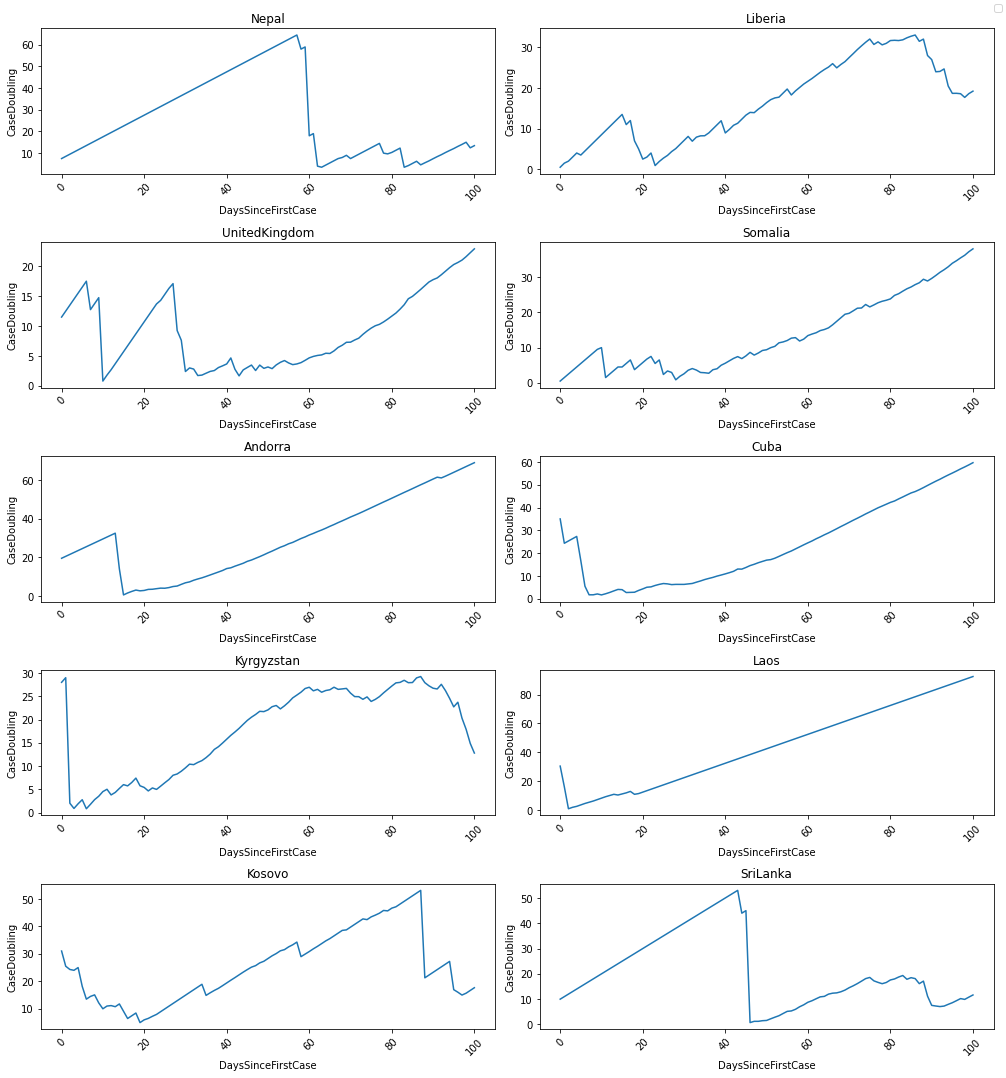

In [23]:

validcountries = list(allmerged['Country'].unique())
## Select some random countries to test plotting
randomcountries = np.random.choice(validcountries, 10, replace=False)
numplots = len(randomcountries)
numcols = 2
numrows = math.ceil(numplots/numcols)
fig, axes = plt.subplots(numrows, numcols)
fig.set_size_inches(14, 3*numrows)
outmetric = 'CaseDoubling'
ignored = []

for i, countryname in enumerate(randomcountries):
    df = allmerged[allmerged['Country']==countryname]
    df = df[df['DaysSinceFirstCase']<=100]
    
    #visScale=1
    irow = math.floor(i/numcols)
    icol = i%numcols
    sns.lineplot(x=df['DaysSinceFirstCase'], y=df[outmetric], ax=axes[irow, icol])
    axes[irow, icol].title.set_text(countryname)
    axes[irow, icol].tick_params('x', labelrotation=45)
    
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
plt.tight_layout()
plotfn = 'outputs/RandomCountriesPolicy{}.pdf'.format(outmetric)
plt.savefig(plotfn, dpi=1200, bbox_inches='tight')



## Is similarity in policy adoption associated with similarity in prolifertion trajectory?

In [117]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
## Consider policy adoption and case proliferation over first 30 days
x = 28
y = 100
firstxDays = allmerged[allmerged['DaysSinceFirstCase']<x]
ydays = allmerged[(allmerged['DaysSinceFirstCase']>=x) & (allmerged['DaysSinceFirstCase']<y)]
cdmatrix = firstxDays.pivot_table(index='Country', columns='DaysSinceFirstCase', aggfunc={'CaseDoubling': np.sum})
cdsimilarity = pd.DataFrame(cosine_similarity(cdmatrix.values))
#cdsimilarity = pd.DataFrame(euclidean_distances(cdmatrix.values))
cdsimilarity.index = cdmatrix.index
cdsimilarity.columns = cdmatrix.index
cdsimilarity

Country          Afghanistan   Albania   Algeria   Andorra    Angola  \
Country                                                                
Afghanistan         1.000000  0.607977  0.679617  0.953964  0.606396   
Albania             0.607977  1.000000  0.516108  0.602443  0.987310   
Algeria             0.679617  0.516108  1.000000  0.662079  0.564085   
Andorra             0.953964  0.602443  0.662079  1.000000  0.595969   
Angola              0.606396  0.987310  0.564085  0.595969  1.000000   
...                      ...       ...       ...       ...       ...   
Vietnam             0.708623  0.794799  0.627506  0.674715  0.813852   
WestBankandGaza     0.585336  0.895491  0.554893  0.574894  0.872832   
Yemen               0.848176  0.632910  0.702128  0.852518  0.637091   
Zambia              0.646855  0.714978  0.860303  0.609922  0.746025   
Zimbabwe            0.530991  0.939787  0.546313  0.511619  0.923640   

Country          Argentina  Australia   Austria  Azerbaijan   Bahrain  ...  \
Country                                                                ...   
Afghanistan       0.591105   0.501014  0.638430    0.749420  0.708346  ...   
Albania           0.629077   0.845614  0.686094    0.669267  0.964156  ...   
Algeria           0.729483   0.508598  0.794526    0.858429  0.504557  ...   
Andorra           0.573177   0.471499  0.622713    0.748036  0.708425  ...   
Angola            0.640559   0.828468  0.703528    0.672175  0.949351  ...   
...                    ...        ...       ...         ...       ...  ...   
Vietnam           0.559234   0.902803  0.649677    0.690652  0.865664  ...   
WestBankandGaza   0.602148   0.835581  0.669722    0.682823  0.843740  ...   
Yemen             0.573363   0.574132  0.614826    0.735158  0.678927  ...   
Zambia            0.785178   0.786896  0.870400    0.882519  0.710618  ...   
Zimbabwe          0.577568   0.871797  0.653579    0.653744  0.879911  ...   

Country          UnitedKingdom  UnitedStates   Uruguay  Uzbekistan  Venezuela  \
Country                                                                         
Afghanistan           0.729378      0.501725  0.495086    0.562962   0.465857   
Albania               0.752343      0.860971  0.808825    0.932501   0.973115   
Algeria               0.720359      0.465719  0.598462    0.528970   0.490487   
Andorra               0.680215      0.460399  0.472789    0.543259   0.439647   
Angola                0.778321      0.842711  0.809227    0.925644   0.969551   
...                        ...           ...       ...         ...        ...   
Vietnam               0.959850      0.886702  0.670995    0.618530   0.769674   
WestBankandGaza       0.729960      0.832419  0.782619    0.864256   0.888122   
Yemen                 0.678548      0.534724  0.511797    0.589099   0.525369   
Zambia                0.896438      0.768500  0.768287    0.640213   0.723081   
Zimbabwe              0.771953      0.866797  0.776764    0.875264   0.952051   

Country           Vietnam  WestBankandGaza     Yemen    Zambia  Zimbabwe  
Country                                                                   
Afghanistan      0.708623         0.585336  0.848176  0.646855  0.530991  
Albania          0.794799         0.895491  0.632910  0.714978  0.939787  
Algeria          0.627506         0.554893  0.702128  0.860303  0.546313  
Andorra          0.674715         0.574894  0.852518  0.609922  0.511619  
Angola           0.813852         0.872832  0.637091  0.746025  0.923640  
...                   ...              ...       ...       ...       ...  
Vietnam          1.000000         0.769709  0.688484  0.837127  0.803363  
WestBankandGaza  0.769709         1.000000  0.749508  0.692522  0.928365  
Yemen            0.688484         0.749508  1.000000  0.622098  0.629727  
Zambia           0.837127         0.692522  0.622098  1.000000  0.735430  
Zimbabwe         0.803363         0.928365  0.629727  0.735430  1.000000  

[164 rows x 164 co

In [118]:
includepolicies = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E1', 'E2', 'H1', 'H2', 'H3']
def getSortedSimilar(countryID, similaritymatrix):
    cd = similaritymatrix.copy()
    cd = cd[cd.index==countryID]
    if(np.amin(cd.values)==0):
        return cd.transpose().sort_values(by=countryID)
    else:
        return cd.transpose().sort_values(by=countryID, ascending=False)
        


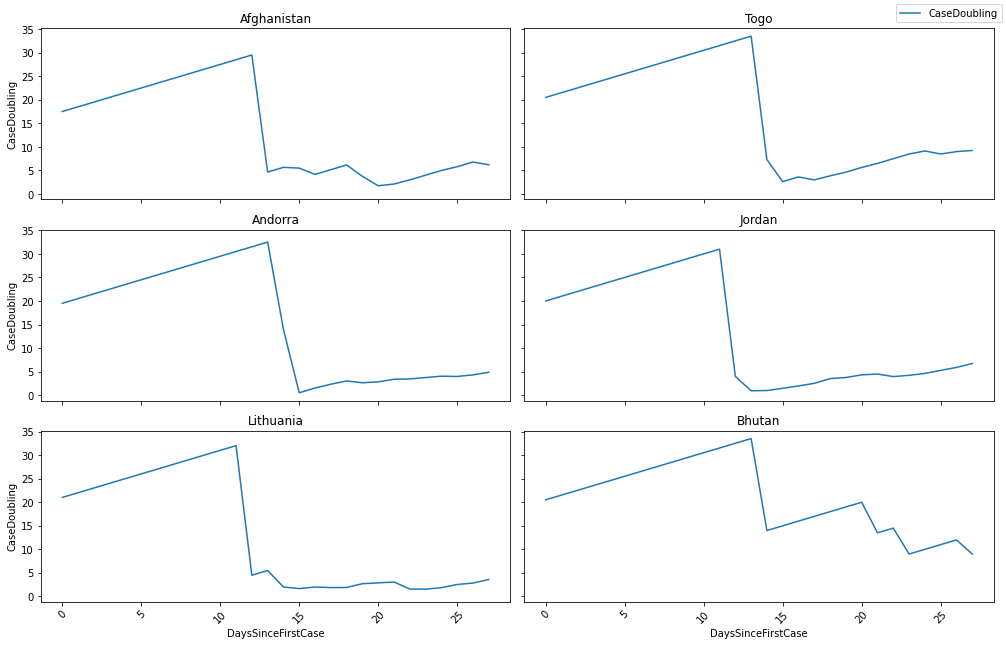

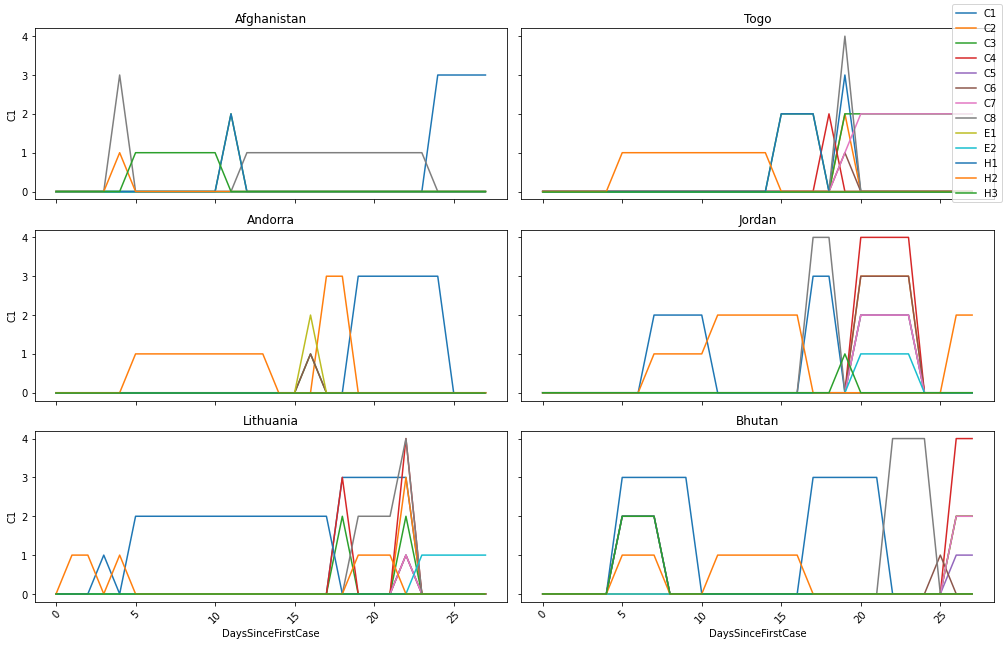

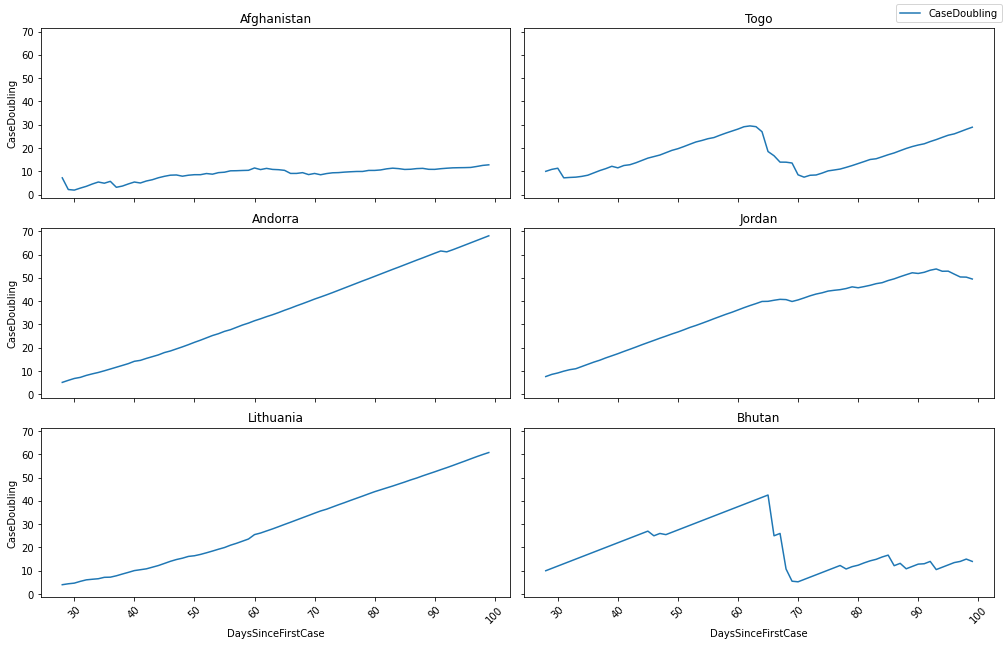

In [119]:
def plotCountries(countrylist, outmetrics=['CaseDoubling'], sdata=allmerged):
    
    numplots = len(countrylist)
    numcols = 2
    numrows = math.ceil(numplots/numcols)
    fig, axes = plt.subplots(numrows, numcols, sharex=True, sharey=True)
    fig.set_size_inches(14, 3*numrows)


    for i, countryname in enumerate(countrylist):
        df = sdata[sdata['Country']==countryname]
    
    
        irow = math.floor(i/numcols)
        icol = i%numcols
        for outmetric in outmetrics:
            sns.lineplot(x=df['DaysSinceFirstCase'], y=df[outmetric], ax=axes[irow, icol], label=outmetric, legend=False)
            axes[irow, icol].title.set_text(countryname)
            axes[irow, icol].tick_params('x', labelrotation=45)
    
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.tight_layout()
    plotfn = 'outputs/{}_{}.pdf'.format(outmetric, countrylist[0])
    plt.savefig(plotfn, dpi=1200, bbox_inches='tight')

selectedsimilar = getSortedSimilar(validcountries[2], cdsimilarity)
plotCountries(countrylist=selectedsimilar.index[0:6], sdata=firstxDays)
plotCountries(selectedsimilar.index[0:6], outmetrics=includepolicies, sdata=firstxDays)
plotCountries(countrylist=selectedsimilar.index[0:6], sdata=ydays)

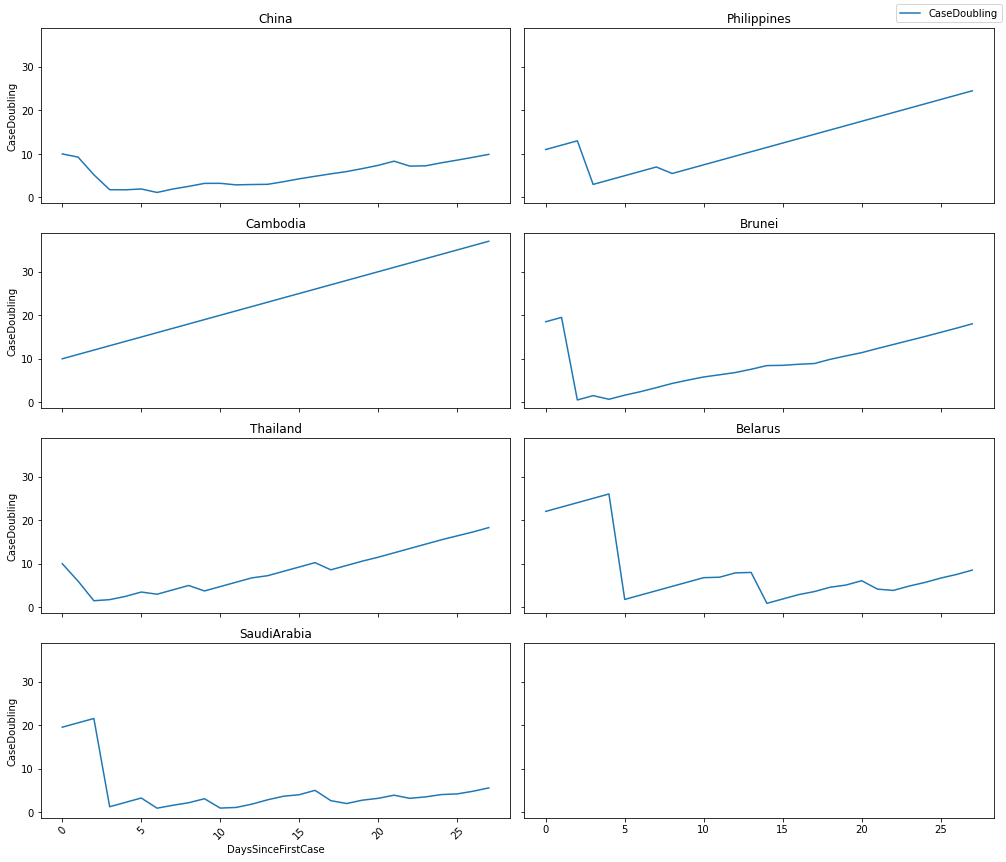

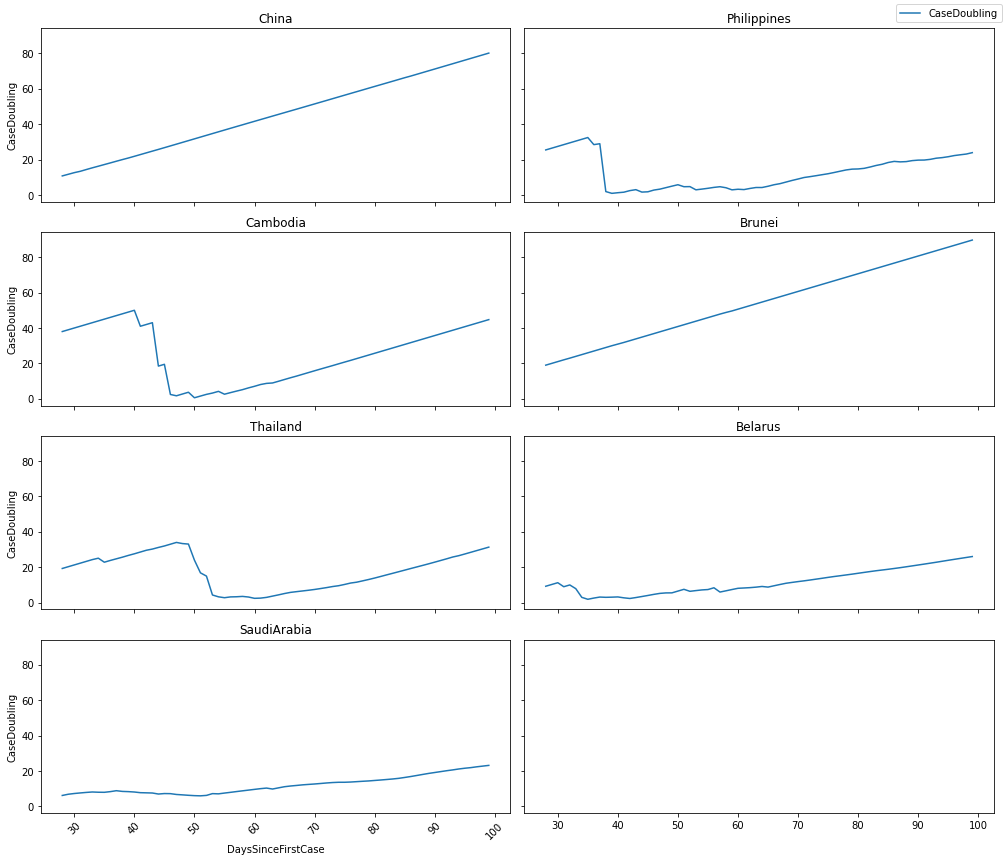

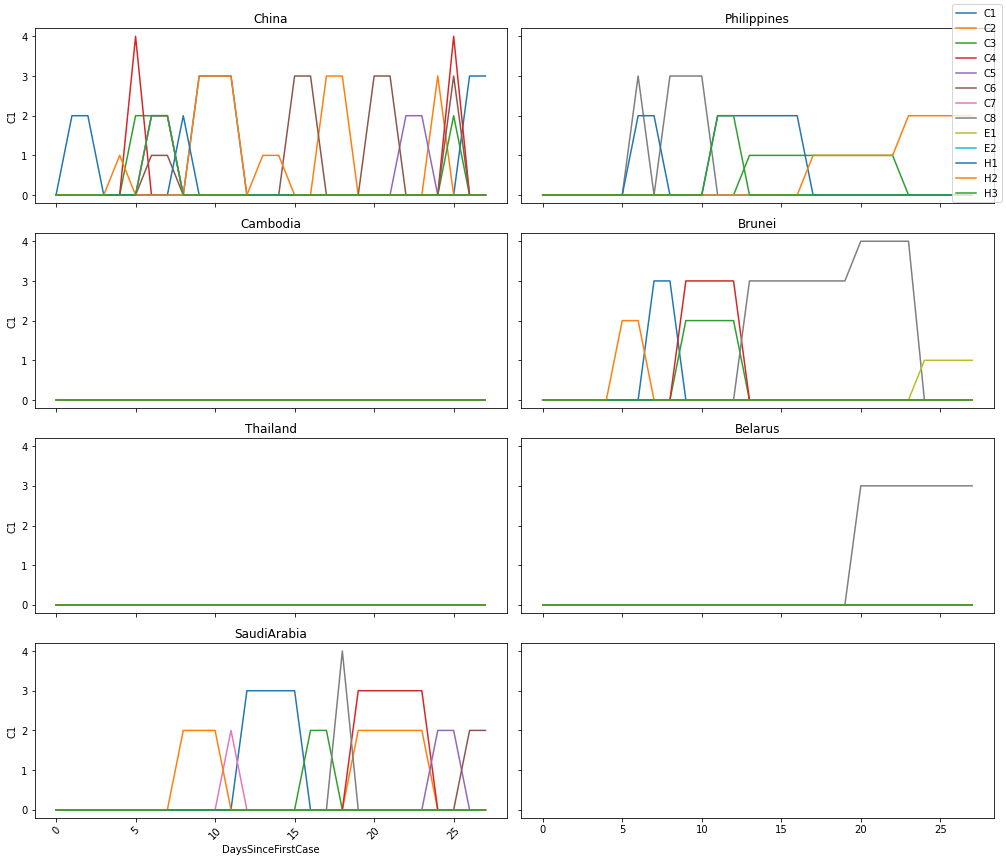

In [120]:

pmatrix = firstxDays.pivot_table(index='Country', columns=['DaysSinceFirstCase'], aggfunc={'C1': np.sum,'C2': np.sum,
                                                                                           'C3': np.sum, 'C4': np.sum,
                                                                                          'C5': np.sum, 'C6': np.sum,
                                                                                          'C7': np.sum, 'C7': np.sum,
                                                                                          'C8': np.sum, 
                                                                                           'E1': np.sum, 'E2': np.sum,
                                                                                           'H1': np.sum, 'H2': np.sum, 'H3': np.sum})
polsimilarity = pd.DataFrame(cosine_similarity(pmatrix.values))
#polsimilarity = pd.DataFrame(euclidean_distances(pmatrix.values))
polsimilarity.index = pmatrix.index
polsimilarity.columns = pmatrix.index

selectedcountry = validcountries[1]
polsimilar = getSortedSimilar(selectedcountry, polsimilarity)
plotCountries(countrylist=[selectedcountry]+list(polsimilar.index[0:6]), sdata=firstxDays)
plotCountries(countrylist=[selectedcountry]+list(polsimilar.index[0:6]), sdata=ydays)
plotCountries(countrylist=[selectedcountry]+list(polsimilar.index[0:6]), outmetrics=includepolicies, sdata=firstxDays)




In [121]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

C:\Users\cchen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


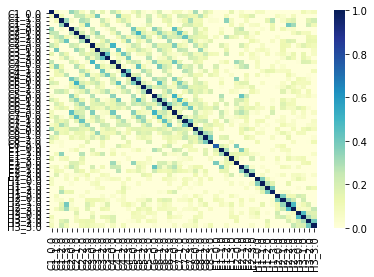

In [122]:
firstxDays['WeeksSinceFirstCase'] = np.floor(firstxDays['DaysSinceFirstCase']/7)
pmatrix = firstxDays.pivot_table(index='Country', columns=['WeeksSinceFirstCase'], aggfunc={'C1': np.max,'C2': np.max,
                                                                                           'C3': np.max, 'C4': np.max,
                                                                                          'C5': np.max, 'C6': np.max,
                                                                                          'C7': np.max, 'C7': np.max,
                                                                                          'C8': np.max, 
                                                                                           'E1': np.max, 'E2': np.max,
                                                                                           'H1': np.max, 'H2': np.max, 'H3': np.max})

pmatrix.columns = [x + '_' + str(y) for (x, y) in pmatrix.columns.values]
cramers_matrix = np.zeros((len(pmatrix.columns), len(pmatrix.columns)))
labels = pmatrix.columns
for (i, r1) in enumerate(pmatrix.columns):
    for (j, r2) in enumerate(pmatrix.columns):
        cramers_matrix[i, j] = cramers_v(pmatrix[r1], pmatrix[r2])
    
ax = sns.heatmap(cramers_matrix, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")  
ax.labelsize = 10
plt.savefig('outputs/PolicyCramersVMatrix.png', dpi=1200, bbox_inches='tight')


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

For n_clusters = 2 The average silhouette_score is : 0.09222512811356913


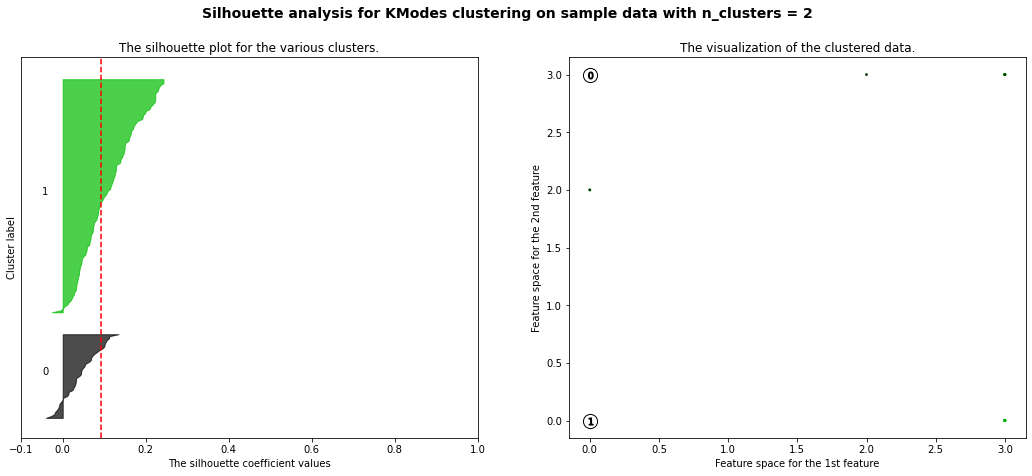

      0    1 feature
0   0.0  0.0  C1_0.0
1   3.0  0.0  C1_1.0
2   3.0  0.0  C1_2.0
3   0.0  0.0  C1_3.0
4   0.0  0.0  C1_4.0
..  ...  ...     ...
60  0.0  0.0  H3_0.0
61  0.0  0.0  H3_1.0
62  0.0  0.0  H3_2.0
63  0.0  0.0  H3_3.0
64  0.0  0.0  H3_4.0

[65 rows x 3 columns]
For n_clusters = 3 The average silhouette_score is : 0.0763669940680482


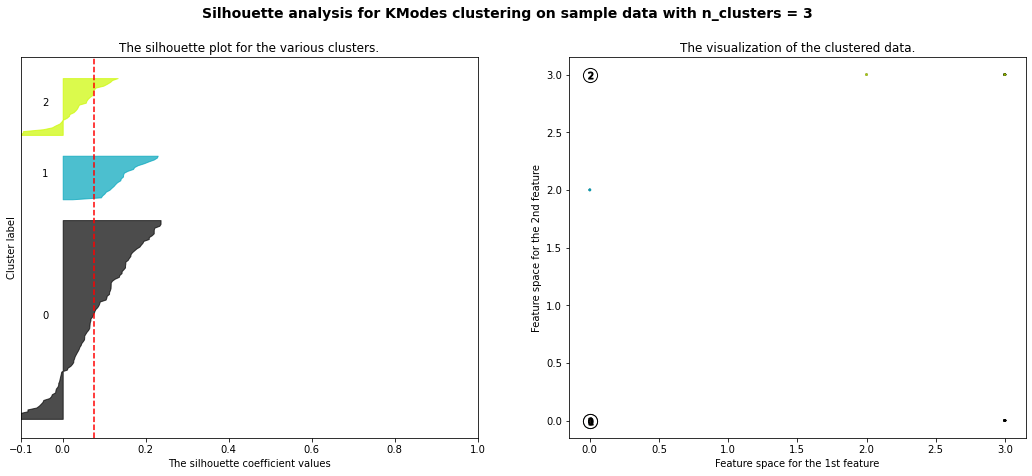

      0    1    2 feature
0   0.0  0.0  0.0  C1_0.0
1   0.0  0.0  3.0  C1_1.0
2   0.0  3.0  0.0  C1_2.0
3   0.0  3.0  0.0  C1_3.0
4   0.0  0.0  0.0  C1_4.0
..  ...  ...  ...     ...
60  0.0  0.0  0.0  H3_0.0
61  0.0  0.0  0.0  H3_1.0
62  0.0  0.0  0.0  H3_2.0
63  0.0  0.0  0.0  H3_3.0
64  0.0  0.0  0.0  H3_4.0

[65 rows x 4 columns]
For n_clusters = 4 The average silhouette_score is : 0.03561086857398926


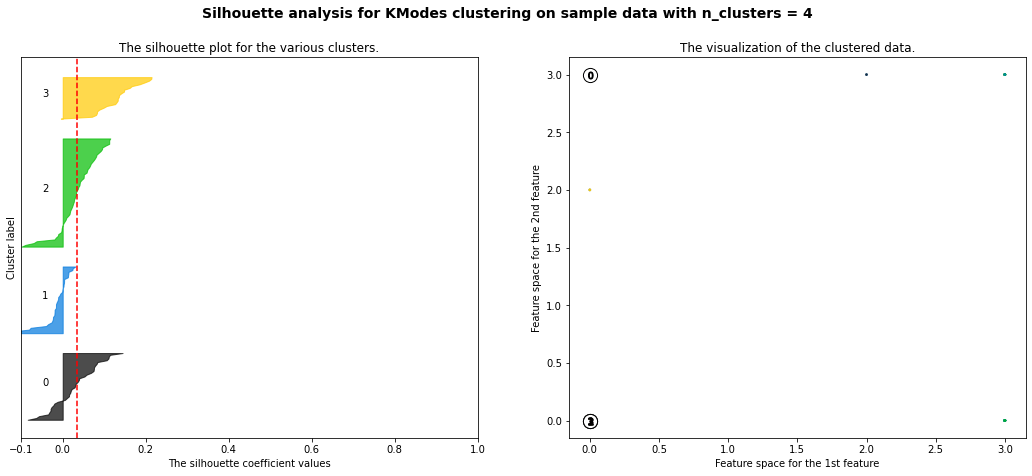

      0    1    2    3 feature
0   0.0  0.0  0.0  0.0  C1_0.0
1   3.0  0.0  0.0  0.0  C1_1.0
2   3.0  0.0  0.0  3.0  C1_2.0
3   0.0  0.0  0.0  0.0  C1_3.0
4   0.0  0.0  0.0  0.0  C1_4.0
..  ...  ...  ...  ...     ...
60  0.0  2.0  0.0  0.0  H3_0.0
61  0.0  2.0  0.0  0.0  H3_1.0
62  0.0  0.0  0.0  0.0  H3_2.0
63  0.0  0.0  0.0  0.0  H3_3.0
64  0.0  0.0  0.0  0.0  H3_4.0

[65 rows x 5 columns]
For n_clusters = 5 The average silhouette_score is : 0.020115297434908464


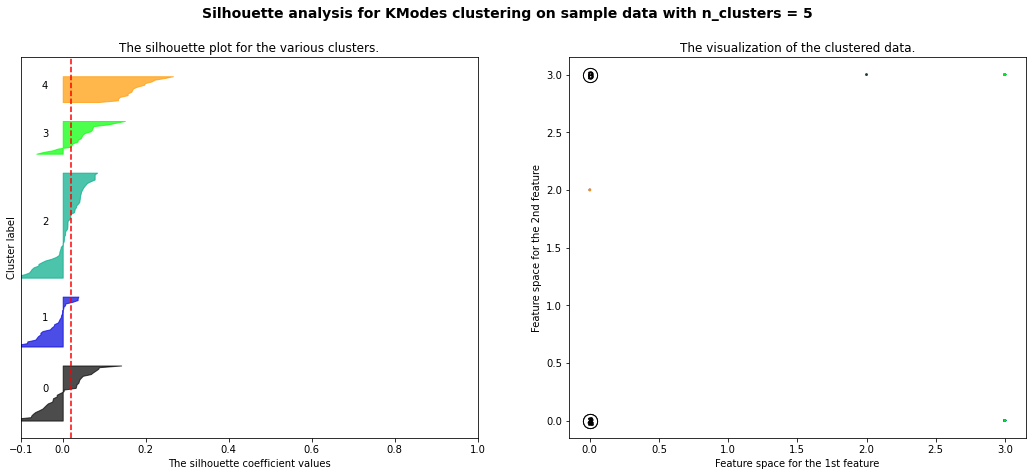

      0    1    2    3    4 feature
0   0.0  0.0  0.0  0.0  0.0  C1_0.0
1   3.0  0.0  0.0  3.0  0.0  C1_1.0
2   3.0  0.0  0.0  0.0  3.0  C1_2.0
3   0.0  0.0  0.0  0.0  3.0  C1_3.0
4   0.0  0.0  0.0  0.0  0.0  C1_4.0
..  ...  ...  ...  ...  ...     ...
60  2.0  2.0  0.0  0.0  0.0  H3_0.0
61  0.0  2.0  0.0  0.0  0.0  H3_1.0
62  0.0  0.0  0.0  0.0  0.0  H3_2.0
63  0.0  0.0  0.0  0.0  0.0  H3_3.0
64  0.0  0.0  0.0  0.0  0.0  H3_4.0

[65 rows x 6 columns]
For n_clusters = 6 The average silhouette_score is : 0.0233043308818797


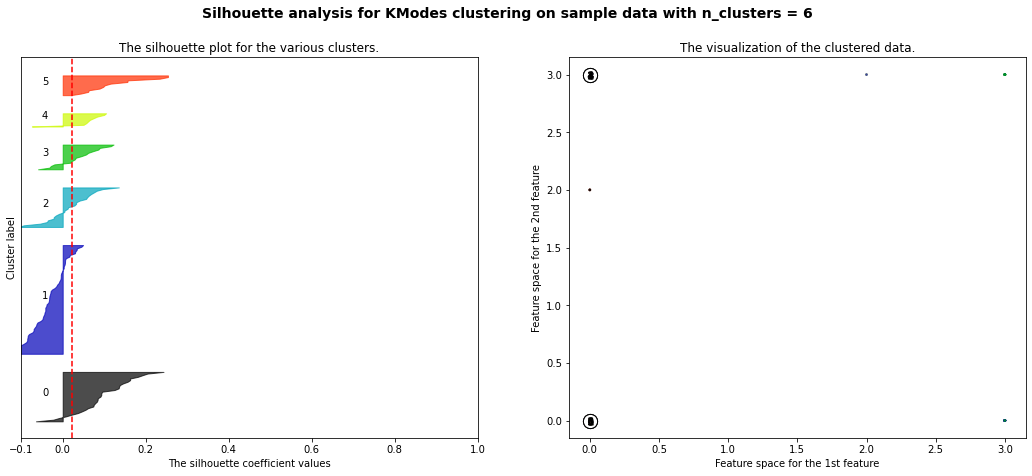

      0    1    2    3    4    5 feature
0   0.0  0.0  0.0  0.0  0.0  0.0  C1_0.0
1   0.0  0.0  3.0  3.0  3.0  0.0  C1_1.0
2   3.0  0.0  3.0  0.0  3.0  0.0  C1_2.0
3   3.0  0.0  0.0  0.0  0.0  0.0  C1_3.0
4   0.0  0.0  0.0  0.0  0.0  0.0  C1_4.0
..  ...  ...  ...  ...  ...  ...     ...
60  0.0  0.0  0.0  0.0  2.0  2.0  H3_0.0
61  0.0  0.0  0.0  0.0  0.0  2.0  H3_1.0
62  0.0  0.0  0.0  0.0  0.0  0.0  H3_2.0
63  0.0  0.0  0.0  0.0  0.0  2.0  H3_3.0
64  0.0  0.0  0.0  0.0  0.0  2.0  H3_4.0

[65 rows x 7 columns]


In [106]:


range_n_clusters = [2,3,4,5,6]
cluster_features = pmatrix.columns

df = pmatrix
X = df[cluster_features].values

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    # (n_clusters+1)*10 for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)    
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    
    #centers = clusterer.cluster_centers_
    #For Kmodes - centroids
    centers = clusterer.cluster_centroids_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KModes clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    centroids = pd.DataFrame([l for l in clusterer.cluster_centroids_]).transpose()
    centroids['feature'] = cluster_features
    #print(bselected)
    print(centroids)
    #print(list(clusterer.cluster_centroids_))

In [88]:

range_n_clusters = [2,3,4,5,6]
cluster_features = pmatrix.columns

df = pmatrix
X = df[cluster_features].values



for n_clusters in range_n_clusters:

    clusterer = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
    cluster_labels = clusterer.fit_predict(X, categorical=list(range(0,len(cluster_features))))
    clusterlab = 'kp_cluster' + str(n_clusters)
    df[clusterlab] = cluster_labels
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    centers = clusterer.cluster_centroids_
    clusters = []
    for i in range(0, n_clusters):
        ncluster =  list(centers[1][i]) + list(centers[0][i])
        clusters.append(ncluster)
    #print(clusters)
    centroids = pd.DataFrame([l for l in clusters]).transpose()
    centroids.index = cluster_features
    #print(bselected)
    print(centroids)
    
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

AssertionError: All columns are categorical, use k-modes instead of k-prototypes.

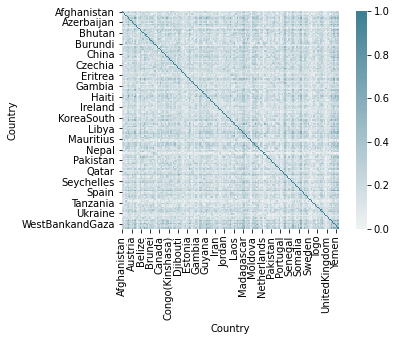

In [317]:
ax = sns.heatmap(
    polsimilarity, 
    vmin=np.amin(polsimilarity.values), vmax=np.amax(polsimilarity.values), center=0,
    cmap=sns.diverging_palette(20, 220, n=163),
    square=True
)

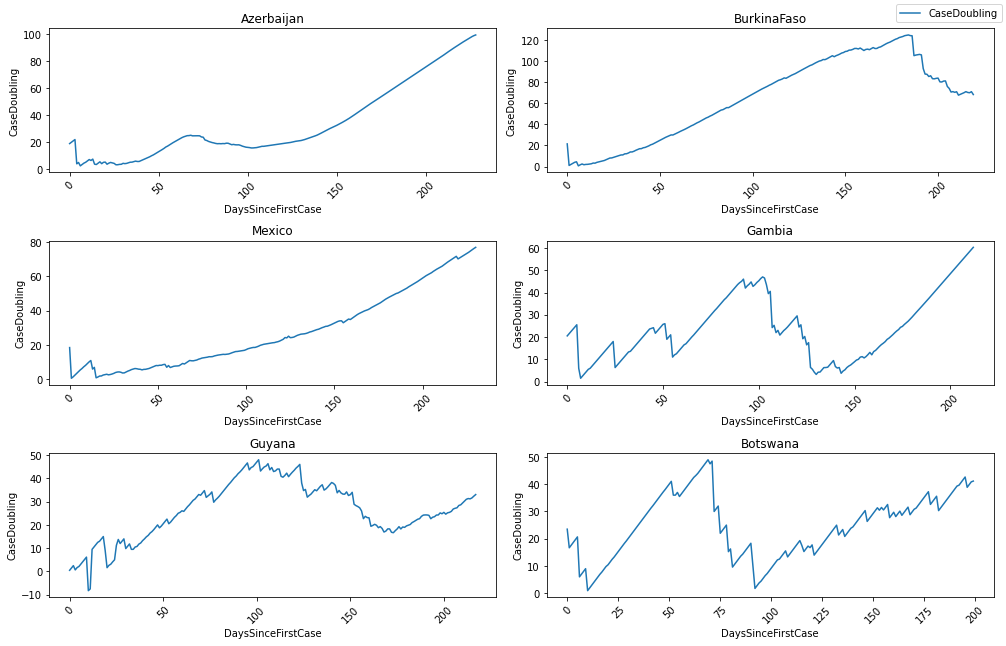

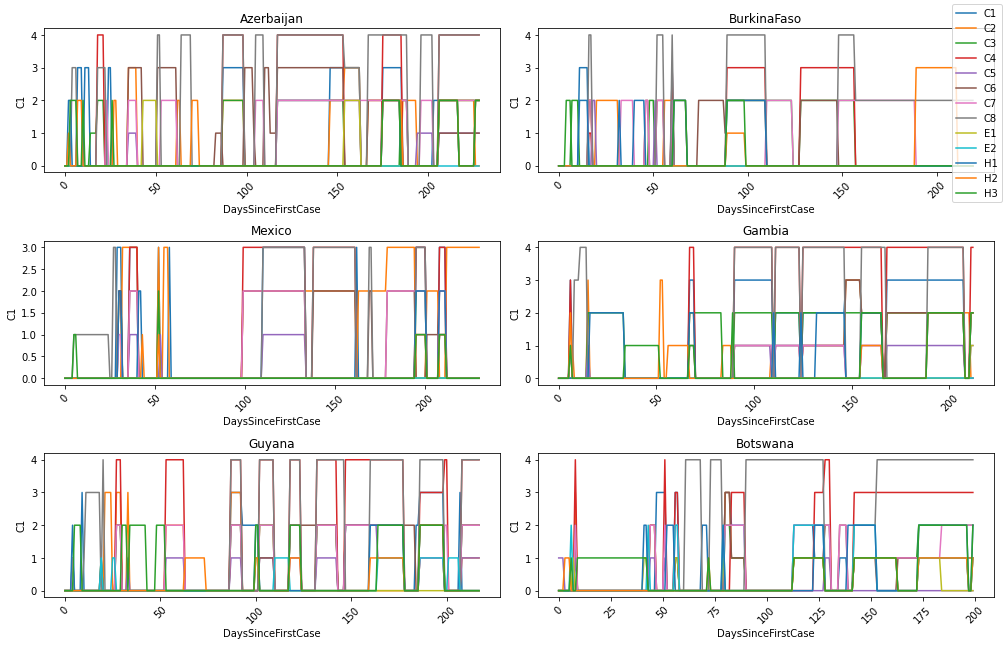

In [302]:
allsimilarity = cdsimilarity + polsimilarity
allsimilar = getSortedSimilar(validcountries[10], polsimilarity)
plotCountries(allsimilar.index[0:6])
plotCountries(allsimilar.index[0:6], outmetrics=includepolicies)


In [241]:
cordata = allmerged[contactpolicies+[outmetric]]
from scipy import stats

corr = cordata.corr()

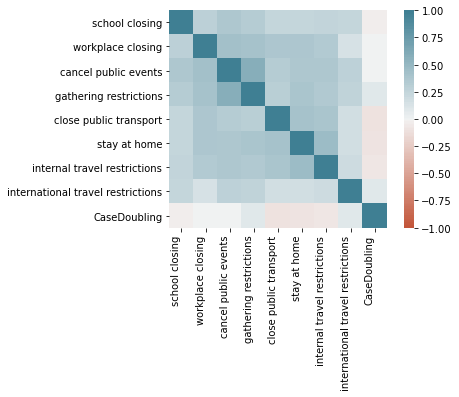

In [111]:
import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=163),
    square=True
)
ax.set_xticklabels(
    [policymap[x] for x in contactpolicies] + [outmetric],
    #ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)
ax.set_yticklabels(
    [policymap[x] for x in contactpolicies] + [outmetric],
    rotation = 0,
);

In [ ]:
import plotly.graph_objects as go

countrymappings = pd.read_csv('data/countrymappings.csv')
countrymappings['compressed'] = countrymappings['Country'].apply(lambda x: x.replace(' ', ''))

def getCode(countryname):
    
    try:        
        code = countrymappings[countrymappings['compressed']==countryname]['Alpha-3 code']
        return code
    except:
        return ''

df = casecounts
locs = df['Country'].apply(lambda x: getCode(x))
print(locs)
fig = go.Figure(data=go.Choropleth(
    locations=locs, 
    z = df['NumDeaths'].astype(int), 
    text=['{}: {} confirmed deaths'.format(x, y) for x, y in zip(df['Country'], df['NumDeaths'])],
    
    colorscale = 'Reds',
    colorbar_title = "Number of deaths",
))

fig.update_layout(
    title_text = 'Deaths' 
)

fig.show()

